**Sections of this notebook**
- Imported libraries
- EDA
- Preprocessing
- 1st iteration
- 2nd iteration (ResNET)
- 3rd iteration (CyclicLR)

# Imports

In [2]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import glob
import cv2

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import tqdm
from PIL import Image
import torch
import gc

train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR




# EDA


## Main goal

The main task is to detect metastases in digital histopathology images of a 96 x 96px size. The images are taken from glass slide microscopes of stained lymph nodes. The major challenge is the presence of tiny metastases that can be as small as single cells and hard to identify. The images use Hematoxylin and Eosin (H&E) staining, resulting in various shades of pink, blue, and violet. Hematoxylin stains nucleic acids blue, whereas Eosin paints proteins in pink shades. The lymph nodes that are small glands filtering the fluid in the lymphatic system are often where breast cancer first spreads. Evaluation of lymph node metastases is part of the TNM classification process, a globally accepted system for understanding the extent of the spread of cancer. This process can be time-consuming and laborious for pathologists due to the large area of tissue they must examine, often resulting in smaller metastases being overlooked.

## Data loading


In [3]:
# DATA_PATH = "/kaggle/input/histopathologic-cancer-detection/"
DATA_PATH = "data"

In [4]:
DEBUG_SCOPE = -1
DEFAULT_LABEL = 0
batch_size = 1024
num_workers = 8
NUM_EPOCHS = 1

In [16]:
data

,id,label,human-readable
0,f38a6374c348f90b587e046aac6079959adf3835,0,non-cancer
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,cancer
2,755db6279dae599ebb4d39a9123cce439965282d,0,non-cancer
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,non-cancer
4,068aba587a4950175d04c680d38943fd488d6a9d,0,non-cancer
...,...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0,non-cancer
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1,cancer
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0,non-cancer
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0,non-cancer


In [5]:
data = pd.read_csv(f"{DATA_PATH}/train_labels.csv")
train = f"{DATA_PATH}/train"
test = f"{DATA_PATH}/test"
data["label"].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

It means that the dataset is slightly imbalanced, it contains the images and labels (0 if not cancer, 1 if cancer)

In [6]:
def map_labels(label):
    if label == 0:
        return "non-cancer"
    elif label == 1:
        return "cancer"

data["human-readable"] = data["label"].apply(map_labels)

In [7]:
def load_image(path):
    rgb_repr = cv2.imread(path)
    r, g, b = cv2.split(rgb_repr)[::-1]
    rgb_img = cv2.merge([r, g, b])  # useful for visibility
    return rgb_img

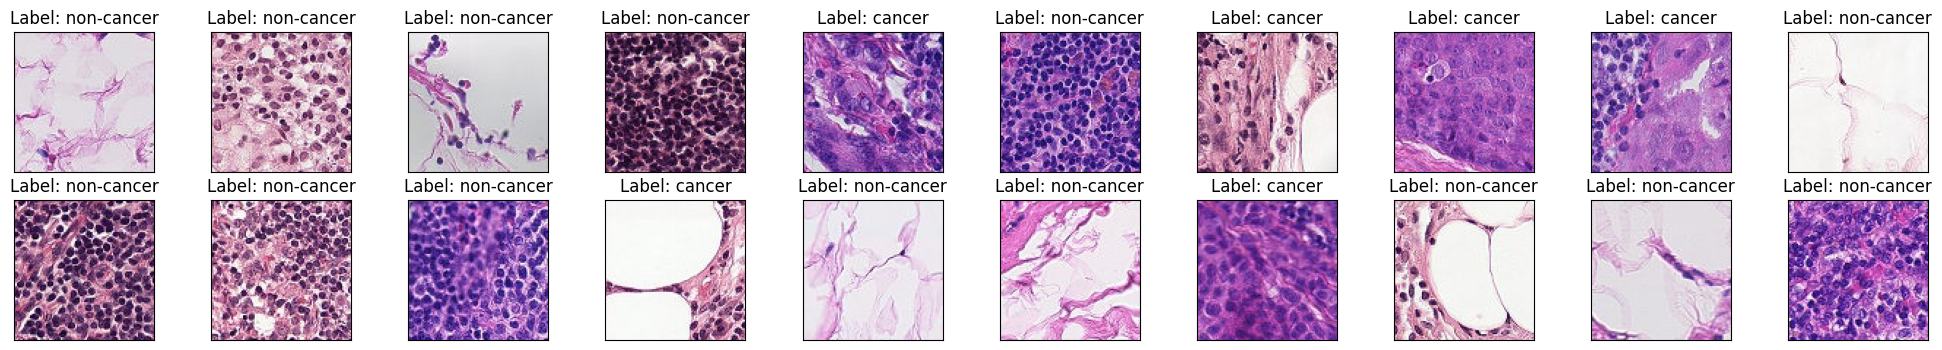

In [8]:
def visualize_random_images(path, labels, num_images=20, figsize=(25, 4)):
    fig = plt.figure(figsize=figsize)
    train_imgs = glob.glob(path + "/*")
    for idx, img in enumerate(np.random.choice(train_imgs, num_images)):
        ax = fig.add_subplot(2, num_images // 2, idx + 1, xticks=[], yticks=[])
        im = load_image(img)
        plt.imshow(im)
        lab = labels.loc[
            labels["id"] == os.path.basename(img).split(".")[0], "human-readable"
        ].values[0]
        ax.set_title(f"Label: {lab}")
    plt.show()

visualize_random_images(f"{DATA_PATH}/train", data)

# Preprocessing

For preprocessing we will use albumentations library (https://albumentations.ai/). It enables us to do augmentations - not only cleaning the dataset by making it more bright, by also by croping imporant parts, as well adding some noise in order to better generalize. 
Introducing noise to images compels the model to prioritize essential features over irrelevant ones, thereby enhancing its ability to generalize to new data. Augmentations can mimic a range of real-world scenarios, including fluctuating lighting conditions, varying camera angles, and occlusions. This increases the model's robustness against different situations it may face in production. By augmenting the training dataset, we also make it more challenging for the model to memorize specific examples, which helps in mitigating the risk of overfitting.

In [10]:
from enum import Enum

class DataType(Enum):
    TRAIN = "train"
    TEST = "test"
    VALIDATION = "validation"  # optional


class CustomDataset(Dataset):
    def __init__(
        self,
        data_pattern,
        datatype=DataType.TRAIN,
        transform=[],
        labels_dict={},
    ):
        self.datatype = datatype
        self.files = glob.glob(data_pattern)
        self.transformations_list = transform
        if self.datatype == DataType.TRAIN:
            self.ids = [os.path.basename(os.path.splitext(i)[0]) for i in self.files]
            new_data = pd.DataFrame(data)
            new_data = new_data.set_index("id")
            self.labels = new_data[new_data.index.isin(self.ids)]["label"].values
            print(self.labels)
            assert len(self.labels) == len(self.files)
        else:
            self.ids = [os.path.basename(os.path.splitext(i)[0]) for i in self.files]
            self.labels = [DEFAULT_LABEL for _ in range(len(self.files))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            img = load_image(self.files[idx])
        except:
            print(idx)
        image = self.transformations_list(image=img)["image"]
        if self.datatype == DataType.TRAIN:
            label = self.labels[idx]
        else:
            label = 0
        return image, label

In [11]:
img_class_dict = {k: v for k, v in zip(data.id, data.label)}
tr, val = train_test_split(
    data[:DEBUG_SCOPE].label, stratify=data[:DEBUG_SCOPE].label, test_size=0.1
)

The transformations are categorized into two types: base and extra transformations:

1. **Base Transformations (`base_transformations`):**
   - **Resize:**
     ```python
     albumentations.Resize(self.dimension, self.dimension)
     ```
     Resizes images to a fixed dimension (default is 224x224), ensuring uniform input size for all images. This is essential for neural networks and is applied to both training and testing data.

2. **Extra Transformations (`extra_transformations`):**
   These augmentations are exclusively used during training to expand the dataset artificially and enhance the model's generalization. They include:
   - **Random Brightness Contrast:**
     ```python
     albumentations.RandomBrightnessContrast()
     ```
     Adjusts the brightness and contrast of the image randomly, aiding the model in becoming invariant to different lighting conditions.
   - **Horizontal Flip:**
     ```python
     albumentations.HorizontalFlip()
     ```
     Randomly flips the image horizontally, augmenting data without altering the subject's essential features.
   - **Shift, Scale, Rotate:**
     ```python
     albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10)
     ```
     Applies random shifts, scales, and rotations to the image, helping the model to ignore slight translations and rotations.
   - **Hue Saturation Value:**
     ```python
     albumentations.HueSaturationValue()
     ```
     Randomly modifies the hue, saturation, and value of the image, enabling the model to handle variations in color.

3. **Normalization and Conversion to Tensor:**
   These steps are included in both training and testing transformations:
   - **Normalization:**
     ```python
     albumentations.Normalize()
     ```
     Normalizes the image, typically to mean zero and variance one.
   - **ToTensorV2:**
     ```python
     ToTensorV2()
     ```
     Converts the image into a PyTorch tensor, the required input format for PyTorch models.

In [12]:
class Transformations:
    def __init__(self, dimension=224):
        self.dimension = dimension

    def base_transformations(self):
       return [albumentations.Resize(self.dimension, self.dimension)]

    def extra_transformations(self):
       return [
           albumentations.RandomBrightnessContrast(), # added for 3rd iteration
           albumentations.HorizontalFlip(),
           albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
           albumentations.HueSaturationValue(),
       ]

    def data_transforms(self):
       print(self.base_transformations() + [ToTensorV2()])
       return albumentations.Compose(self.base_transformations() + self.extra_transformations() + [albumentations.Normalize(), ToTensorV2()]) 

    def data_transforms_test(self):
       print(self.base_transformations() + [ToTensorV2()])
       return albumentations.Compose(self.base_transformations() + [albumentations.Normalize(), ToTensorV2()])

transforms = Transformations()

dataset = CustomDataset(
    data_pattern=f"{DATA_PATH}/train/*.tif",
    datatype=DataType.TRAIN,
    transform=transforms.data_transforms(),
    labels_dict=img_class_dict,
)
test_set = CustomDataset(
    data_pattern=f"{DATA_PATH}/test/*.tif",
    datatype=DataType.TEST,
    transform=transforms.data_transforms_test(),
)

class DataLoaderCreation:
    def __init__(self, data_set, batch_size=128, num_workers=20):
        self.data_set = data_set
        self.batch_size = batch_size
        self.num_workers = num_workers

    def create_dataloader(self, indices):
        sampler = SubsetRandomSampler(indices)
        return torch.utils.data.DataLoader(
            self.data_set, batch_size=self.batch_size, sampler=sampler, num_workers=self.num_workers
        )

dataloader_train = DataLoaderCreation(dataset)
dataloader_test = DataLoaderCreation(test_set)

train_loader = dataloader_train.create_dataloader(list(tr.index))
valid_loader = dataloader_train.create_dataloader(list(val.index))
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, num_workers=num_workers
)

[Resize(p=1.0, height=224, width=224, interpolation=1), ToTensorV2(p=1.0, transpose_mask=False)]
[0 1 0 ... 0 0 1]
[Resize(p=1.0, height=224, width=224, interpolation=1), ToTensorV2(p=1.0, transpose_mask=False)]


In [13]:


from enum import Enum



class DataType(Enum):
    TRAIN = "train"
    TEST = "test"
    VALIDATION = "validation"  # optional


class CustomDataset(Dataset):
    def __init__(
        self,
        data_pattern,
        datatype=DataType.TRAIN,
        transform=[],
        labels_dict={},
    ):
        self.datatype = datatype
        self.files = sorted(glob.glob(data_pattern))
        self.transformations_list = transform
        if self.datatype == DataType.TRAIN:
            self.ids = [os.path.basename(os.path.splitext(i)[0]) for i in self.files]
            new_data = pd.DataFrame(data)
            new_data = new_data.set_index("id")
            self.new_data = new_data.sort_values('id')
            self.labels = self.new_data[self.new_data.index.isin(self.ids)]["label"].values
            print(self.labels)
            assert len(self.labels) == len(self.files)
        else:
            self.ids = [os.path.basename(os.path.splitext(i)[0]) for i in self.files]
            self.labels = [DEFAULT_LABEL for _ in range(len(self.files))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            img = img = cv2.imread(self.files[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except:
            print(idx)
        image = self.transformations_list(image=img)["image"]
        if self.datatype == DataType.TRAIN:
            label = self.labels[idx]
        else:
            label = 0
        return image, label

In [14]:
dataset = CustomDataset(
    data_pattern=f"{DATA_PATH}/train/*.tif",
    datatype=DataType.TRAIN,
    transform=transforms.data_transforms(),
    labels_dict=img_class_dict,
)

[Resize(p=1.0, height=224, width=224, interpolation=1), ToTensorV2(p=1.0, transpose_mask=False)]
[1 0 0 ... 1 1 0]


In [13]:
class Training:
    def __init__(
        self,
        model,
        train_loader,
        valid_loader,
        criterion,
        optimizer,
        scheduler,
        n_epochs=1,
        patience=5,
    ):
        self.model = model
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.n_epochs = n_epochs
        self.patience = patience
        self.p = 0
        self.stop = False
        self.valid_loss_min = np.Inf

    def train_epoch(self):
        self.model.train()
        train_loss = []
        for batch_i, (data, target) in tqdm.tqdm(enumerate(self.train_loader)):
            data, target = data.cuda(), target.cuda()

            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output[:, 1], target.float())
            train_loss.append(loss.item())

            loss.backward()
            self.optimizer.step()

        return np.mean(train_loss)

    def validate_epoch(self):
        self.model.eval()
        val_loss = []

        for batch_i, (data, target) in enumerate(self.valid_loader):
            data, target = data.cuda(), target.cuda()
            output = self.model(data)

            loss = self.criterion(output[:, 1], target.float())

            val_loss.append(loss.item())

        return np.mean(val_loss)

    def fit(self):
        for epoch in range(1, self.n_epochs + 1):
            train_loss = self.train_epoch()
            valid_loss = self.validate_epoch()
            self.scheduler.step(valid_loss)
            if valid_loss <= self.valid_loss_min:
                torch.save(self.model.state_dict(), "model.pt")
                self.valid_loss_min = valid_loss
                self.p = 0

            if valid_loss > self.valid_loss_min:
                self.p += 1
                print(f"{self.p} epochs of increasing val loss")
                if self.p > self.patience:
                    print("Stopping training")
                    self.stop = True
                    break

            if self.stop:
                break

In [14]:
def get_preds(model, loader, device, n_pred=1):
    model.eval()
    preds = []
    with torch.no_grad():
        for batch_i, (data, target) in tqdm.tqdm(enumerate(loader)):
            gc.collect()
            torch.cuda.empty_cache()
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds.extend(output[:, n_pred].detach().cpu().numpy())
    return preds

In [15]:
def generate_submission(test_set, preds, data_path, submission_file_name):
    test_preds = pd.DataFrame({"imgs": test_set.ids, "preds": preds})
    sub = pd.read_csv(f"{data_path}/sample_submission.csv")
    sub = pd.merge(sub, test_preds, left_on="id", right_on="imgs")
    sub = sub[["id", "preds"]]
    sub.columns = ["id", "label"]

    sub.to_csv(submission_file_name, index=False)
    print(f"Submission file saved as {submission_file_name}")

    return sub

# Tested model architectures

## CNN - iteration 1

In the first round I will use CNN. A Convolutional Neural Network (CNN) is a specialized type of artificial neural network designed specifically for processing structured grid data, such as images. CNNs are particularly effective for image recognition tasks due to their unique architecture, which is inspired by the visual cortex of animals.


In my implementation:

`_make_conv_block` constructs a convolutional block consisting of several layers:
  - **Convolutional Layer**: A `nn.Conv2d` layer with a 3x3 kernel and padding of 2.
  - **Batch Normalization**: A `nn.BatchNorm2d` layer to normalize the activations.
  - **LeakyReLU Activation**: A `nn.LeakyReLU` activation function that introduces non-linearity.
  - **Max Pooling Layer**: A `nn.MaxPool2d` layer with a 2x2 kernel and a stride of 2 to reduce spatial dimensions.

```python
def _make_conv_block(self, in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
```

### Forward Method
- **Forward Pass**: The `forward` method defines the forward pass of the network. This method is called to compute the output of the network given an input `x`.
  - **Apply convolutional blocks (hence name!)**: The input `x` is sequentially passed through all the convolutional blocks.
  - **Average Pooling**: After the convolutional layers, `x` is passed through the average pooling layer.
  - **Flatten to vector **: The output of the pooling layer is flattened to a vector.
  - **Fully Connected Layer / Linear layer **: The flattened vector is then passed through the fully connected layer `self.fc` to produce the final output.

```python
def forward(self, x):
    for conv_block in self.conv_blocks:
        x = conv_block(x)
    x = self.avg(x)
    x = x.view(-1, 512 * 1 * 1)
    x = self.fc(x)
    return x
```


The CNN architecture consists of multiple convolutional blocks that progressively extract features from the input image. Each convolutional block includes a convolutional layer, batch normalization, LeakyReLU activation, and max pooling. After the series of convolutional blocks, the network applies average pooling to reduce the spatial dimensions and then flattens the result before passing it through a fully connected layer to produce class scores. This architecture is suitable for image classification tasks.Sure, let me break down this Convolutional Neural Network (CNN) in more approachable terms.


In [18]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.conv_block_configs = [(3, 32), (32, 64), (64, 128), (128, 256), (256, 512)]

        self.conv_blocks = nn.ModuleList(
            [
                self._make_conv_block(in_channels, out_channels)
                for in_channels, out_channels in self.conv_block_configs
            ]
        )

        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, num_classes)

    def _make_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        x = self.avg(x)
        x = x.view(-1, 512 * 1 * 1)
        x = self.fc(x)
        return x

In [16]:
# model_conv = CNN().cuda()
# model_conv.cuda()
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.005, momentum=0.99)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [17]:
# training = Training(
#     model_conv,
#     train_loader,
#     valid_loader,
#     criterion,
#     optimizer,
#     scheduler,
#     n_epochs=NUM_EPOCHS,
#     patience=2,
# )

# training.fit()

In [18]:
# preds = get_preds(training.model, test_loader, "cuda:0", 1)

# generate_submission(test_set, preds, DATA_PATH, "submission.csv")

## ResNET - transfer learning - iteration 2

Because I was not happy with results I wanted to levarage transfer learning. Transfer learning is extensively applied in image recognition due to its numerous advantages, including reduced training time and improved performance with limited data by using pre-trained models, which also generalize better to diverse tasks. Robust architectures such as ResNet (Residual Network), introduced to tackle the vanishing gradient problem, enhance these benefits through the use of residual blocks that add the input directly to the output, allowing effective training even in very deep networks. ResNet's flexible depth variants (e.g., ResNet-50, ResNet-101) enable customization for different complexities and have shown state-of-the-art performance in benchmarks such as ImageNet. This combination of transfer learning and resilient architectures like ResNet allows developers to achieve high accuracy in image recognition tasks efficiently, even with fewer resources and smaller datasets. I chose to use resnet-50

In [19]:
model_conv = torchvision.models.resnet50(pretrained=True)
for i, param in model_conv.named_parameters():
    param.requires_grad = False

/media/veracrypt4/repos/kaggle-cnn/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/veracrypt4/repos/kaggle-cnn/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(2048, 2)

In [21]:
model_conv.cuda()
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.005, momentum=0.99)
# scheduler = CyclicLR(optimizer, base_lr=0.010, max_lr=0.01,  mode='triangular2') # used for iteration 3 and 4

scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [23]:
training = Training(
    model_conv,
    train_loader,
    valid_loader,
    criterion,
    optimizer,
    scheduler,
    n_epochs=NUM_EPOCHS,
    patience=5,
)

training.fit()

1548it [03:12,  8.06it/s]
/media/veracrypt4/repos/kaggle-cnn/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [ ]:
preds = get_preds(training.model, test_loader, "cuda:0", 1)
generate_submission(test_set, preds, DATA_PATH, "submission.csv")

## ResNET with CyclicLR - iteration 3

After achieving an approximate 0.06 increase in both the private and public scores, I conducted research to implement Cyclic LR as well. In this approach the learning rate oscillates within a specified range. It initially increases from a minimum value to a maximum, then decreases back to the minimum. This method has been demonstrated to be more efficient and can lead to faster convergence for certain models.

# Results and discussion

| Iteration | Private Score | Public Score |
|-----------|------------|------------|
 Iteration 3 - ResNET - CyclicLR              | 0.9126        | 0.9204       |
| Iteration 2 - ResNET                         | 0.9111        | 0.9198       |
| Iteration 1 - CNN                            | 0.8424        | 0.8657       |


1. The primary aim was to detect metastases in small digital histopathology images measuring 96 x 96 pixels.
2. This evaluation process is time-consuming and labor-intensive for pathologists, leading to potential oversight of smaller metastases.
3. Performance metrics for different iterations show that a ResNET model with CyclicLR achieved the highest scores, followed by plain ResNET and then a CNN.
4. The scores indicate that more advanced models, such as ResNET with CyclicLR, provide better detection accuracy for metastases.

### What can be done better?

At a minimum, conduct extensive hyperparameter tuning using techniques such as Bayesian optimization or grid search to find the optimal settings for learning rates, batch sizes, and dropout rates. Additionally, explore advanced learning rate schedules and optimizers beyond CyclicLR, such as learning rate warm-up, cosine annealing, or the AdamW optimizer. Also other transfer learning models might be used.


# Sources

1. https://medium.com/@rcpandey/image-transformation-techniques-a-comprehensive-guide-42e7c303f847
2. https://insightsimaging.springeropen.com/articles/10.1007/s13244-018-0639-9
3. https://medium.com/@kirudang/deep-learning-computer-vision-using-transfer-learning-resnet-18-in-pytorch-skin-cancer-8d5b158893c5
4. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
5. https://cs231n.github.io/transfer-learning/
6. https://github.com/brianmanderson/Cyclical_Learning_Rate
7. https://medium.com/analytics-vidhya/cyclical-learning-rates-a922a60e8c04